In [32]:
import glob
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import seawater as sw
from scipy import linalg
import gsw
import sys
sys.path.append('/Users/paban23/Research/PhD/S-MODE/S-MODE-IOP/IOP_codes')
sys.path.append('/Users/paban23/Research/PhD/S-MODE/SD_ADCP_Analyses')
#sys.path.insert(0,'/home/pab21003/PhD/Practice/NRT/Maps-main/tools/')
from itertools import combinations
# from utils import *
from utils import *
from KPE_functions import *
# from spectra_utils import *
from scipy import signal
from scipy.special import gammainc
from scipy.stats import kurtosis, skew
from scipy import stats
from scipy import linalg
from scipy.signal import fftconvolve
#%matplotlib widget
import math

In [33]:
sd_all = xr.open_dataset('/Users/paban23/Research/PhD/S-MODE/SD_ADCP_Analyses/Data/All_SDs_merged_4_50m_deep/1hz/all_SMODE_SDs_ADCP.nc').sel(trajectory=['1026','1048','1085','1087'])[["u","v"]]

/opt/anaconda3/envs/research/lib/python3.10/site-packages/xarray/coding/times.py:251: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/opt/anaconda3/envs/research/lib/python3.10/site-packages/xarray/coding/times.py:251: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [34]:
t1,t2 = '2022-10-19-18:00','2022-10-21-06:00' 

In [35]:
ds1 = sd_all.sel(time=slice(t1,t2)).reset_coords(['longitude', 'latitude']).isel(cell_depth=np.arange(0,48,2))

In [36]:
ds1_subset_5min = ds1.resample(time='5min').mean(dim='time')
ds1_subset_3min = ds1.resample(time='3min').mean(dim='time')

In [37]:
ds26 = ds1.sel(trajectory ='1026')
ds48 = ds1.sel(trajectory ='1048')
ds85 = ds1.sel(trajectory ='1085')
ds87 = ds1.sel(trajectory ='1087')


In [38]:
ds26_5min = ds1_subset_5min.sel(trajectory ='1026')
ds48_5min = ds1_subset_5min.sel(trajectory ='1048').interp(cell_depth = ds26_5min.cell_depth)
ds85_5min = ds1_subset_5min.sel(trajectory ='1085').interp(cell_depth = ds26_5min.cell_depth)
ds87_5min = ds1_subset_5min.sel(trajectory ='1087').interp(cell_depth = ds26_5min.cell_depth)

In [39]:
ds26_3min = ds1_subset_3min.sel(trajectory ='1026')
ds48_3min = ds1_subset_3min.sel(trajectory ='1048').interp(cell_depth = ds26_3min.cell_depth)
ds85_3min = ds1_subset_3min.sel(trajectory ='1085').interp(cell_depth = ds26_3min.cell_depth)
ds87_3min = ds1_subset_3min.sel(trajectory ='1087').interp(cell_depth = ds26_3min.cell_depth)

In [40]:
all_ds = ['ds26','ds48','ds85','ds87']
for ds in all_ds:
    #put the cartesian coordinate into the data
    exec(ds+'_5min["x"],'+ds+'_5min["y"] = ll2xy('+ds+'_5min.longitude,'+ds+'_5min.latitude,-125.1-0.01,36.79-0.02)',globals())  # changed 36.89 to 36.79
    exec(ds+'_5min["u_uncertainty"] = '+ds+'.u.resample(time="5min").std(dim="time")/np.sqrt(300)',globals())
    exec(ds+'_5min["v_uncertainty"] = '+ds+'.v.resample(time="5min").std(dim="time")/np.sqrt(300)',globals())

In [41]:
all_ds = ['ds26','ds48','ds85','ds87']
for ds in all_ds:
    #put the cartesian coordinate into the data
    exec(ds+'_3min["x"],'+ds+'_3min["y"] = ll2xy('+ds+'_3min.longitude,'+ds+'_3min.latitude,-125.1-0.01,36.79-0.02)',globals())  # changed 36.89 to 36.79
    exec(ds+'_3min["u_uncertainty"] = '+ds+'.u.resample(time="3min").std(dim="time")/np.sqrt(180)',globals())
    exec(ds+'_3min["v_uncertainty"] = '+ds+'.v.resample(time="3min").std(dim="time")/np.sqrt(180)',globals())

In [42]:
ds5min_all = xr.concat([ds26_5min,ds48_5min,ds85_5min,ds87_5min],dim='trajectory')
ds3min_all = xr.concat([ds26_3min,ds48_3min,ds85_3min,ds87_3min],dim='trajectory')

In [43]:
#ds5min_all.plot.scatter(x='x',y='y')

In [44]:
#IOP TIMES
t1s, t1e = '2022-10-19-18:00','2022-10-20-01:15'   #'2022-10-18-19:00','2022-10-20-20:15'
t2s, t2e = '2022-10-20-01:20','2022-10-20-09:10'
t3s, t3e = '2022-10-20-09:15','2022-10-20-19:30'
# t4s, t4e = '2022-10-20-15:00','2022-10-20-19:30'
t5s, t5e = '2022-10-20-19:35','2022-10-21-06:00'

In [45]:
sd_all_sub_iop = xr.concat([ds5min_all.sel(time=slice(t1s,t1e)),\
                     ds5min_all.sel(time=slice(t2s,t2e)),\
                     ds5min_all.sel(time=slice(t3s,t3e)),\
                       # ds5min_all.sel(time=slice(t4s,t4e)),\
                       ds5min_all.sel(time=slice(t5s,t5e)),],dim="legs")#.isel(cell_depth=np.arange(0,48,2))

In [46]:
sd_all_sub_iop_3min = xr.concat([ds3min_all.sel(time=slice(t1s,t1e)),\
                     ds3min_all.sel(time=slice(t2s,t2e)),\
                     ds3min_all.sel(time=slice(t3s,t3e)),\
                       # ds5min_all.sel(time=slice(t4s,t4e)),\
                       ds3min_all.sel(time=slice(t5s,t5e)),],dim="legs")#.isel(cell_depth=np.arange(0,48,2))

In [47]:
def rotate_coords(ds):
    for i in range(len(ds.legs.values)):
        if i==0:
            ds_nnull = ds.isel(legs=i).where(~ds.isel(legs=i).isnull(), drop=True)
            _,_,coefs = least_squares(ds_nnull.y.values.flatten(),ds_nnull.x.values.flatten()) #get the mean track using LS
            slope = coefs[1]
            x_m,y_m = ds_nnull.isel(trajectory=0).x.values, coefs[0] + slope*ds_nnull.x.median(dim='trajectory').values  # try median instead of mean
            theta_radians = np.arctan(slope)
            coords = x_m +1j*y_m
            rot_coords = coords*np.exp(-1j*theta_radians)

            leg_coord = ds_nnull.x + 1j*ds_nnull.y
            rotated_leg = leg_coord*np.exp(-1j*theta_radians)
            ds_nnull['x_rot'] = rotated_leg.real                 #Add the rotated x,y coordinate for each saildrone to the data
            ds_nnull['y_rot'] = rotated_leg.imag

            ds_nnull['mean_rotated_x'] = (('time',), rotated_leg.real.mean(dim='trajectory').values)
            ds_nnull['mean_rotated_y'] = (('time',), rotated_leg.imag.mean(dim='trajectory').values)
        else:
            ds_add = ds.isel(legs=i).where(~ds.isel(legs=i).isnull(), drop=True)
            _,_,coefs = least_squares(ds_add.y.values.flatten(),ds_add.x.values.flatten()) #get the mean track using LS
            slope = coefs[1]
            x_m,y_m = ds_add.isel(trajectory=0).x.values, coefs[0] + slope*ds_add.isel(trajectory=0).x.values
            theta_radians = np.arctan(slope)
            coords = x_m +1j*y_m
            rot_coords = coords*np.exp(-1j*theta_radians)

            leg_coord = ds_add.x + 1j*ds_add.y
            rotated_leg = leg_coord*np.exp(-1j*theta_radians)
            ds_add['x_rot'] = rotated_leg.real                 #Add the rotated x,y coordinate for each saildrone to the data
            ds_add['y_rot'] = rotated_leg.imag

            ds_add['mean_rotated_x'] = (('time',), rotated_leg.real.mean(dim='trajectory').values)
            ds_add['mean_rotated_y'] = (('time',), rotated_leg.imag.mean(dim='trajectory').values)
            ds_nnull = xr.concat([ds_nnull,ds_add],dim='legs')
            
            
    return ds_nnull

In [48]:
rot_ds  = rotate_coords(sd_all_sub_iop)
rot_ds_3min  = rotate_coords(sd_all_sub_iop_3min)

In [50]:
# Calculate the weighted uncertainity of kinematic properties (Vorticity, Divergence, and Strain-rate)
def KPE_uncertainity(A,c_u,c_v,B_u,B_v,z_u,z_v,n,strain_rate,u_uncert,v_uncert,sig2u,sig2v): # We provide the position(distance matrix), the velocities, and the least-square coefficients that includes mean velocities and velocity gradients
    # provide only 5 u's i.e., u_all[:,i]
    #calculate residual sum square SSres
    ux = c_u[1]
    uy = c_u[2]
    vx = c_v[1] 
    vy = c_v[2]
    # SSres_u = z_u.T@z_u - c_u.T@B_u.T@z_u
    # SSres_v = z_v.T@z_v - c_v.T@B_v.T@z_v
    
    # caclulate residual mean square MSres = SSres/(n-p) = sigma square 
    # sigma_square_u = SSres_u/(n-3)
    # sigma_square_v = SSres_v/(n-3)
    sigma_square_u_net = sig2u #+ (np.mean(u_uncert)**2)
    sigma_square_v_net = sig2v #+ (np.mean(v_uncert)**2)
    
    # Calculate the diagonal elements of Cjj = A.T@A, which is correlation?
    #Cjj = linalg.inv(A.T@A)
    #r_xy = np.corrcoef(xi,yi)[0,1]
    Z_u = linalg.inv(A.T@linalg.inv(sigma_square_u_net)@A)   #@linalg.inv(V_u)
    Z_v = linalg.inv(A.T@linalg.inv(sigma_square_v_net)@A)   #@linalg.inv(V_v)
    
    Ux_uncert = 2*np.sqrt(np.diag(Z_u)[1])
    Uy_uncert = 2*np.sqrt(np.diag(Z_u)[2])
    
    Vx_uncert = 2*np.sqrt(np.diag(Z_v)[1])
    Vy_uncert = 2*np.sqrt(np.diag(Z_v)[2])
    
    vort_uncert = np.sqrt(Vx_uncert**2 + Uy_uncert**2)
    div_uncert = np.sqrt(Ux_uncert**2 + Vy_uncert**2)
    
    strain_rate_uncert = np.sqrt((((ux-vy)*Ux_uncert)**2 + ((ux-vy)*Vy_uncert)**2 + ((vx+uy)*Vx_uncert)**2 +((vx+uy)*Uy_uncert)**2)/(strain_rate**2))
    
    return vort_uncert, div_uncert, strain_rate_uncert
    
    


In [51]:
def create_box_data(ds_names):
    combined_ds1 = ds_names
    # Calculate the mean longitude
    central_x = combined_ds1.mean_rotated_x
    central_y = combined_ds1.mean_rotated_y
    
    box_size = 2  # 1 km in meters
    box_half_size = box_size / 2
    #combined_ds1 = combined_ds1.set_coords(['longitude', 'latitude','x', 'y','u','v','u_uncertainty','v_uncertainty']) # Add all the variables and coordinates you need here 
                                                                                    #otherwise the dataset does not crop corretly for the variable not included here
    count = 0
    for j in range(len(combined_ds1.legs.values)):
        #print(j)
        combined_ds =  combined_ds1.isel(legs=j).where(~combined_ds1.isel(legs=j).isnull(), drop=True)# finish coding here
        #combined_ds = combined_ds.set_coords(['longitude', 'latitude','x', 'y','u','v',\      #we can comment this part no need to convert change the variables to coordiates, it works fine
                     #                         'u_uncertainty','v_uncertainty','x_rot',\
                  #                            'y_rot','mean_rotated_x','mean_rotated_y'])
        for i in range(len(combined_ds.time)):
            k = i+count
            #print(midpoint_lon[k].values)
            x_min = central_x.isel(legs=j)[k] - box_half_size 
            x_max = central_x.isel(legs=j)[k] + box_half_size
            y_min = central_y.isel(legs=j)[k] - box_half_size   # for some reason the y constarin was not working properly and for now the y constain does not matter that much
            y_max = central_y.isel(legs=j)[k] + box_half_size

            box = ((combined_ds.y_rot > y_min) & (combined_ds.y_rot < y_max) & (combined_ds.x_rot > x_min) & (combined_ds.x_rot < x_max) )
            # try: 
                            # Generalize for any number of trajectories
            all_trajectories = []
            for traj in range(len(combined_ds.trajectory)):
                trajectory_ds = combined_ds.isel(trajectory=traj).where(box.isel(trajectory=traj), drop=True)
                all_trajectories.append(trajectory_ds)
            
            concatenated_trajectories = xr.concat(all_trajectories, dim='trajectory')
            
            x_prime = (concatenated_trajectories.x - np.mean(concatenated_trajectories.x))
            y_prime = (concatenated_trajectories.y - np.mean(concatenated_trajectories.y))
            #print(x_prime.values.flatten())
            points = np.array(list(zip(x_prime.values[~np.isnan(x_prime.values)].flatten(),y_prime.values[~np.isnan(y_prime.values)].flatten())))
            
            if len(points) < 4:
                # print(concatenated_trajectories.longitude.count().values)
                # print(x_prime.values[~np.isnan(x_prime.values)].flatten())
                eig = np.nan
            else:
                eig = eig_ratio(points)

            concatenated_trajectories['x_prime'] = x_prime
            concatenated_trajectories['y_prime'] = y_prime
            concatenated_trajectories['eig'] = eig

            if k == 0:
                box_ds = concatenated_trajectories
            else:
                #print(k)
                box_ds = xr.concat([box_ds, concatenated_trajectories], dim='box')

        count +=i
    
    return box_ds

In [52]:
def calculate_values(A,u,v,B_u,B_v,z_u,z_v,f,p,u_uncert,v_uncert,sig2u,sig2v):
    wi_u = linalg.inv(sig2u)
    wi_v = linalg.inv(sig2v)
    c_u= linalg.inv(A.T@wi_u@A)@A.T@wi_u@u
    c_v= linalg.inv(A.T@wi_v@A)@A.T@wi_v@v

    vorticity = c_v[1] - c_u[2]
    divergence = c_u[1] + c_v[2]
    sigmaS = c_v[1] + c_u[2]
    sigmaN = c_u[1] - c_v[2]
    strain_rate = np.sqrt(sigmaS**2 + sigmaN**2)
    
    vort_uncert, div_uncert, strain_uncert = KPE_uncertainity(A,c_u,c_v,B_u,B_v,z_u,z_v,p,strain_rate,u_uncert,v_uncert,sig2u,sig2v)

    return vorticity / f, divergence / f, strain_rate / f, vort_uncert/f, div_uncert/f, strain_uncert/f

In [53]:
def vort_div(x, y, u_all, v_all, u_un_all, v_un_all, eig):
    omega = 2*np.pi/(3600*24) + 2*np.pi/(365*86400)
    f = 2*omega*np.sin((37.4*np.pi)/180)

    vort, div, strain, vort_uncert, div_uncert, strain_uncert = [], [], [], [], [], []

    for i in range(len(x[:, 0, 0])):
        valid_indices = ~np.isnan(u_all[i, :, :])
        #print(valid_indices)

        # Continue only if the eig value satisfies the condition
        if abs(eig[i]) > 0.2:
            p = np.sum(valid_indices) 
            if p > 6:
                A = np.ones((p, 3))
                A[:, 1] = x[i, :, :][valid_indices]
                A[:, 2] = y[i, :, :][valid_indices]
                
                u_uncert = u_un_all[i,:,:][valid_indices]
                v_uncert = v_un_all[i,:,:][valid_indices]
                sig2u = np.diag(u_uncert**2)
                sig2v = np.diag(v_uncert**2)
                w_u = np.sqrt(1/u_uncert**2)   # 1/sigma = w
                w_v = np.sqrt(1/v_uncert**2)

                B_u = A*w_u[:, np.newaxis]
                B_v = A*w_v[:, np.newaxis]
                # print(i)
                # print('number of points:{}',p)
                u = u_all[i,:,:][valid_indices]
                v = v_all[i,:,:][valid_indices]
                z_u = u*w_u
                z_v = v*w_v

                # u_all_nonan = u_all[i, :, :][valid_indices]
                # v_all_nonan = v_all[i, :, :][valid_indices]

                vorticity, divergence, strain_rate, vorticity_uncert, divergence_uncert, strainrate_uncert = calculate_values(A,u,v,B_u,B_v,z_u,z_v,f,p,u_uncert,v_uncert,sig2u,sig2v)
            else:
                vorticity, divergence, strain_rate, vorticity_uncert, divergence_uncert, strainrate_uncert = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
        else:
            vorticity, divergence, strain_rate, vorticity_uncert, divergence_uncert, strainrate_uncert = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

        vort.append(vorticity)
        div.append(divergence)
        strain.append(strain_rate)
        vort_uncert.append(vorticity_uncert)
        div_uncert.append(divergence_uncert)
        strain_uncert.append(strainrate_uncert)

    return div, vort, strain, vort_uncert, div_uncert, strain_uncert


In [54]:


# SD parameters required to calculate kinematic properties
def number_of_sd_parameters(c,ds_names): #n was there in place of c 
    #c = np.arange(n)
    k=0
    ds = create_box_data(ds_names)  
    xp = ds.x_prime*1000
    yp = ds.y_prime*1000
    u_all = ds.u
    v_all = ds.v
    u_un_all = ds.u_uncertainty
    v_un_all = ds.v_uncertainty
    eig = ds.eig
    #print(ds.u[:,0].values)
    
    return xp,yp,u_all,v_all,u_un_all,v_un_all,eig

def calculate_kinematic_properties(n,r,ds_names):
    if r==n:
        c = np.arange(n)
        xp_c,yp_c,u_all_c,v_all_c,u_un_all_c,v_un_all_c,eig = number_of_sd_parameters(c,ds_names)
        kinematic_prop_c = [vort_div(xp_c.values,yp_c.values,u_all_c.isel(cell_depth=i).values,\
                                              v_all_c.isel(cell_depth=i).values,\
                                              u_un_all_c.isel(cell_depth=i).values,\
                                              v_un_all_c.isel(cell_depth=i).values,eig) for i in range(0,24)]                  # should start from 0 instead of 1
        div, vort, strain, vort_uncert, div_uncert, strain_uncert = np.array(kinematic_prop_c)[:,0,:], np.array(kinematic_prop_c)[:,1,:],\
                                                                    np.array(kinematic_prop_c)[:,2,:], np.array(kinematic_prop_c)[:,3,:],\
                                                                    np.array(kinematic_prop_c)[:,4,:], np.array(kinematic_prop_c)[:,5,:]


    elif r<n:                   #nCr (combination syntax)
        #print('start')
        count = 0
        l = np.arange(0,n)
        l2 = list(combinations(l,r))
        for i in range(len(l2)):
            c = l2[i]
            xp_c,yp_c,u_all_c,v_all_c,u_un_all_c,v_un_all_c,eig = number_of_sd_parameters(c,ds_names)
            kinematic_prop_c = [vort_div(xp_c.values,yp_c.values,u_all_c.isel(cell_depth=i).values,\
                                                  v_all_c.isel(cell_depth=i).values,\
                                                  u_un_all_c.isel(cell_depth=i).values,\
                                              v_un_all_c.isel(cell_depth=i).values,eig) for i in range(0,24)]                  # should start from 0 instead of 1
            div_c, vort_c, strain_c, vort_uncert_c, div_uncert_c, strain_uncert_c = np.array(kinematic_prop_c)[:,0,:], np.array(kinematic_prop_c)[:,1,:],\
                                                                                    np.array(kinematic_prop_c)[:,2,:], np.array(kinematic_prop_c)[:,3,:],\
                                                                              np.array(kinematic_prop_c)[:,4,:], np.array(kinematic_prop_c)[:,5,:]
            if count == 0:
                div, vort, strain, vort_uncert, div_uncert, strain_uncert = div_c[np.newaxis], vort_c[np.newaxis], strain_c[np.newaxis],\
                                                                            vort_uncert_c[np.newaxis], div_uncert_c[np.newaxis], strain_uncert_c[np.newaxis]
                count+=1
            else:
                div, vort, strain, vort_uncert, div_uncert, strain_uncert = np.vstack([div,div_c[np.newaxis]]), np.vstack([vort,vort_c[np.newaxis]]),\
                                                                            np.vstack([strain,strain_c[np.newaxis]]),np.vstack([vort_uncert,vort_uncert_c[np.newaxis]]),\
                                                                            np.vstack([div_uncert,div_uncert_c[np.newaxis]]), np.vstack([strain_uncert,strain_uncert_c[np.newaxis]])
                
    return xr.DataArray(div),xr.DataArray(vort),xr.DataArray(strain), xr.DataArray(vort_uncert),xr.DataArray(div_uncert),xr.DataArray(strain_uncert)
        
        
    


In [55]:
#del vort_div

In [56]:
ds_names = ['ds26_5min','ds48_5min','ds85_5min','ds87_5min']
ds_names_3min = ['ds26_3min','ds48_3min','ds85_3min','ds87_3min']

# ds_names_2SD = ['ds26_5min','ds85_5min']
# ds_conv_names = ['ds26_conv_2min','ds48_conv_2min','ds85_conv_2min','ds87_conv_2min']

In [57]:
div, vort, strain, vort_uncert, div_uncert, strain_uncert = calculate_kinematic_properties(4,4,rot_ds)

In [58]:
div_3min, vort_3min, strain_3min, vort_uncert_3min, div_uncert_3min, strain_uncert_3min = calculate_kinematic_properties(4,4,rot_ds_3min)

In [59]:
depths =  rot_ds.cell_depth.values

In [60]:
div = xr.DataArray(div).assign_coords({'dim_1':div.dim_1}).assign_coords({'dim_0':depths,'dim_1':rot_ds.time.values}).rename({'dim_0':'depths','dim_1': 'time'})
vort = xr.DataArray(vort).assign_coords({'dim_1':vort.dim_1}).assign_coords({'dim_0':depths,'dim_1':rot_ds.time.values}).rename({'dim_0':'depths','dim_1': 'time'})
strain = xr.DataArray(strain).assign_coords({'dim_1':strain.dim_1}).assign_coords({'dim_0':depths,'dim_1':rot_ds.time.values}).rename({'dim_0':'depths','dim_1': 'time'})

div_3min = xr.DataArray(div_3min).assign_coords({'dim_1':div_3min.dim_1}).assign_coords({'dim_0':depths,'dim_1':rot_ds_3min.time.values}).rename({'dim_0':'depths','dim_1': 'time'})
vort_3min = xr.DataArray(vort_3min).assign_coords({'dim_1':vort_3min.dim_1}).assign_coords({'dim_0':depths,'dim_1':rot_ds_3min.time.values}).rename({'dim_0':'depths','dim_1': 'time'})
strain_3min = xr.DataArray(strain_3min).assign_coords({'dim_1':strain_3min.dim_1}).assign_coords({'dim_0':depths,'dim_1':rot_ds_3min.time.values}).rename({'dim_0':'depths','dim_1': 'time'})

In [61]:
div_uncert = xr.DataArray(div_uncert).assign_coords({'dim_1':div_uncert.dim_1}).assign_coords({'dim_0':depths,'dim_1':rot_ds.time.values}).rename({'dim_0':'depths','dim_1': 'time'})
vort_uncert = xr.DataArray(vort_uncert).assign_coords({'dim_1':vort_uncert.dim_1}).assign_coords({'dim_0':depths,'dim_1':rot_ds.time.values}).rename({'dim_0':'depths','dim_1': 'time'})
strain_uncert = xr.DataArray(strain_uncert).assign_coords({'dim_1':strain_uncert.dim_1}).assign_coords({'dim_0':depths,'dim_1':rot_ds.time.values}).rename({'dim_0':'depths','dim_1': 'time'})

div_uncert_3min = xr.DataArray(div_uncert_3min).assign_coords({'dim_1':div_uncert_3min.dim_1}).assign_coords({'dim_0':depths,'dim_1':rot_ds_3min.time.values}).rename({'dim_0':'depths','dim_1': 'time'})
vort_uncert_3min = xr.DataArray(vort_uncert_3min).assign_coords({'dim_1':vort_uncert_3min.dim_1}).assign_coords({'dim_0':depths,'dim_1':rot_ds_3min.time.values}).rename({'dim_0':'depths','dim_1': 'time'})
strain_uncert_3min = xr.DataArray(strain_uncert_3min).assign_coords({'dim_1':strain_uncert_3min.dim_1}).assign_coords({'dim_0':depths,'dim_1':rot_ds_3min.time.values}).rename({'dim_0':'depths','dim_1': 'time'})

In [62]:
color2 = 'dodgerblue'
color1 = 'saddlebrown'
#clrs = ['coral','g','m','navy','maroon','saddlebrown']

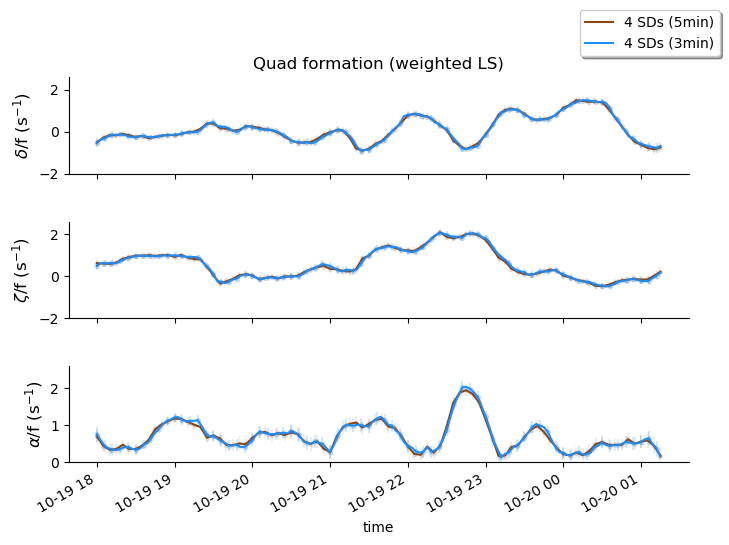

In [64]:
fig,ax = plt.subplots(3,1,figsize=(8,5))
div[0,:].sel(time=slice(t1s,t1e)).plot(ax=ax[0],color=color1)
div_3min[0,:].sel(time=slice(t1s,t1e)).plot(ax=ax[0],color=color2)
ax[0].errorbar(div[0,:].sel(time=slice(t1s,t1e)).time.values,div[0,:].sel(time=slice(t1s,t1e)).values,div_uncert[0,:].sel(time=slice(t1s,t1e)).values,fmt='.',color=color1,alpha=0.1)
ax[0].errorbar(div_3min[0,:].sel(time=slice(t1s,t1e)).time.values[::2],div_3min[0,:].sel(time=slice(t1s,t1e)).values[::2],div_uncert_3min[0,:].sel(time=slice(t1s,t1e)).values[::2],fmt='.',color=color2,alpha=0.2)

ax[0].legend(('4 SDs (5min)','4 SDs (3min)',),bbox_to_anchor=(1.05,1.7),borderaxespad=0., frameon=True, shadow=True)
ax[0].set_ylim(-2,2.6)
ax[0].set_ylabel(r'$\delta$/f (s$^{-1}$)',fontsize=12)
ax[0].set_xlabel('')
#ax[0].set_yticks(fontsize=10)
#ax[0].set_xticks(color='w')
ax[0].set_xticklabels([])
vort[0,:].sel(time=slice(t1s,t1e)).plot(ax=ax[1],color=color1)
vort_3min[0,:].sel(time=slice(t1s,t1e)).plot(ax=ax[1],x='time',color=color2)
ax[1].errorbar(vort[0,:].sel(time=slice(t1s,t1e)).time.values,vort[0,:].sel(time=slice(t1s,t1e)).values,vort_uncert[0,:].sel(time=slice(t1s,t1e)).values,fmt='.',color=color1,alpha=0.1)
ax[1].errorbar(vort_3min[0,:].sel(time=slice(t1s,t1e)).time.values[::2],vort_3min[0,:].sel(time=slice(t1s,t1e)).values[::2],vort_uncert_3min[0,:].sel(time=slice(t1s,t1e)).values[::2],fmt='.',color=color2,alpha=0.2)

ax[1].set_ylim(-2,2.6)
ax[1].set_ylabel(r'$\zeta$/f (s$^{-1}$)',fontsize=12)
ax[1].set_xticklabels([])
ax[1].set_xlabel('')
strain[0,:].sel(time=slice(t1s,t1e)).plot(ax=ax[2],color=color1)
strain_3min[0,:].sel(time=slice(t1s,t1e)).plot(ax=ax[2],x='time',color=color2)
ax[2].errorbar(strain[0,:].sel(time=slice(t1s,t1e)).time.values,strain[0,:].sel(time=slice(t1s,t1e)).values,strain_uncert[0,:].sel(time=slice(t1s,t1e)).values,fmt='.',color=color1,alpha=0.1)
ax[2].errorbar(strain_3min[0,:].sel(time=slice(t1s,t1e)).time.values[::2],strain_3min[0,:].sel(time=slice(t1s,t1e)).values[::2],strain_uncert_3min[0,:].sel(time=slice(t1s,t1e)).values[::2],fmt='.',color=color2,alpha=0.2)

ax[2].set_ylim(0,2.6)
ax[2].set_ylabel(r'$\alpha$/f (s$^{-1}$)',fontsize=12)

plt.subplots_adjust(hspace=0.5)
ax[0].set_title('Quad formation (weighted LS)')
ax[1].set_title('')
ax[2].set_title('')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
plt.savefig('./Plots/KPE_error_prop_4SDs_5min_vs_3min_Quad_IOP1_1stleg_overleaf_updated_uncert_aspect_0.2.png',bbox_inches='tight',dpi=150)